# Classification with `pyani` output

This notebook contains experiments in generating *continuous* classifications from `pyani` output. The general principle is as follows:

1. Generate a graph with each isolate as a node, whose edges contain information about %identity and %coverage for the pairwise comparison between genomes
2. Prune the graph by removing edges that fall below a minimum level of %coverage.
3. Identify all (*k*-complete) graphs at this level, and note the minimum %identity *i*

Then, for each of the initial graphs:

* Progressively prune the graph edges, from lowest to highest %identity.
* When a *k*-complete graph is noted, we record this as a specific grouping/classification as $G_{m,n}$ where $m$ is the %coverage used to construct the initial graph, and $n$ is the %identity at which the $k$-complete graph is first observed.

# Implementing the algorithm

### Python dependencies

We're using `networkx` for the graph manipulations, and `pygraphviz` for some rendering.

In [1]:
%pylab inline

import csv
import os
import networkx as nx
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Initial Graph construction

Load the coverage and identity data as `Pandas` dataframes:

In [2]:
# Data from a Buchnera comparison
#covfile = "Buchnera_ANIm/ANIm_alignment_coverage.tab"
#idfile = "Buchnera_ANIm/ANIm_percentage_identity.tab"

# Data from an Alcanivorax comparison
#covfile = "tests/Alcanivorax_ANIm/ANIm_alignment_coverage.tab"
#idfile = "tests/Alcanivorax_ANIm/ANIm_percentage_identity.tab"
#labels = "tests/Alcanivorax/labels.txt"

# Data from SRE comparison
indir = "tests/SRE"
prefix = "SRE"

# Data from Streptomyces comparison
#indir = "tests/Streptomyces"
#prefix = "Strep"

# Define filesnames
covfile = os.path.join(indir, "ANIm_alignment_coverage.tab")
idfile = os.path.join(indir, "ANIm_percentage_identity.tab")
labels = os.path.join(indir, "labels.txt")
classes = os.path.join(indir, "classes.txt")

# Load pyani outputs into dataframes
covdata = pd.DataFrame.from_csv(covfile, sep='\t')
iddata = pd.DataFrame.from_csv(idfile, sep='\t')

Create nodes and edges for an undirected graph with the *minimal* coverage (identity should be the same in both directions)

In [3]:
# Our node names will be the isolate labels
node_names = covdata.columns

# Load labels for isolates
with open(labels, mode='r') as fh:
    reader = csv.reader(fh, delimiter='\t')
    labeldict = {rows[0]:rows[1] for rows in reader
                 if rows[0] in node_names}

# Load classes for isolates
with open(classes, mode='r') as fh:
    reader = csv.reader(fh, delimiter='\t')
    classdict = {rows[0]:rows[1] for rows in reader
                 if rows[0] in node_names}

In [4]:
# Loop over each isolate ID and get all coverage/identity values
rows_list = []
for idx, node_from in enumerate(node_names[:-1]):
    for node_to in node_names[idx+1:]:
        datadict = {'from': node_from,
                    'to': node_to,
                    'coverage': min(covdata[node_from][node_to],
                                    covdata[node_to][node_from]),
                    'identity': iddata[node_from][node_to]}
        rows_list.append(datadict)

# Create dataframe of from/to nodes, coverage and identity (in that order)
node_data = pd.DataFrame(rows_list, columns=['from', 'to', 'coverage', 'identity'])

Build a `networkx` undirected graph from this data

In [5]:
# Create graph
G = nx.Graph()

# Function to add an edge to the graph
def add_edge(row, graph, cov_thresh=0.5):
    if row['coverage'] >= cov_thresh:
        graph.add_edge(row['from'], row['to'],
                       coverage=row['coverage'],
                       identity=row['identity'],
                       difference=1-row['identity'],
                       logident=abs(log(row['identity'])))

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    G.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(G,), cov_thresh=0.5)

## Rendering graphs

Visualising the graph with `pylab`:

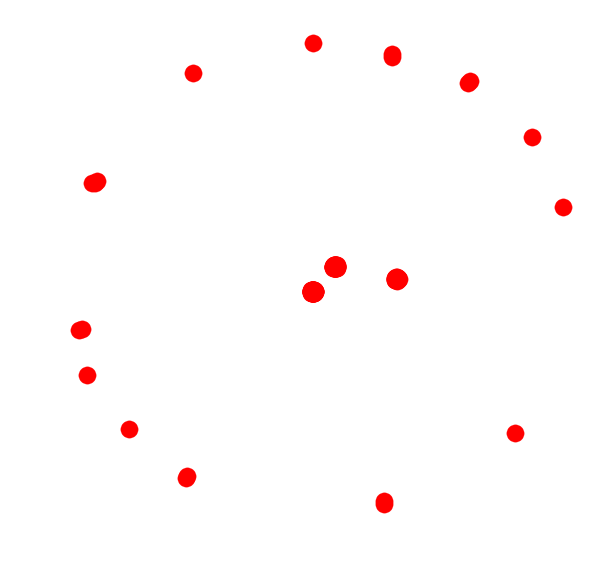

In [6]:
fig = figure(figsize=(10,10))  # NetworkX respects the current pylab figure/axes
ax = fig.add_subplot(1,1,1)
# k determines the distance between nodes, iterations controls rounds of layout
layout = nx.spring_layout(G, weight='identity', k=0.1, iterations=200)
nx.draw(G, pos=layout, ax=ax)
outfname = "/Users/lpritc/Desktop/{0}_ANIm_graph.pdf".format(prefix)
savefig(outfname)

In [7]:
# Save graph 
nx.write_gml(G, 'sre_anim_graph.gml')

Visualising, and labelling the nodes using a dictionary, testing a number of layout options:

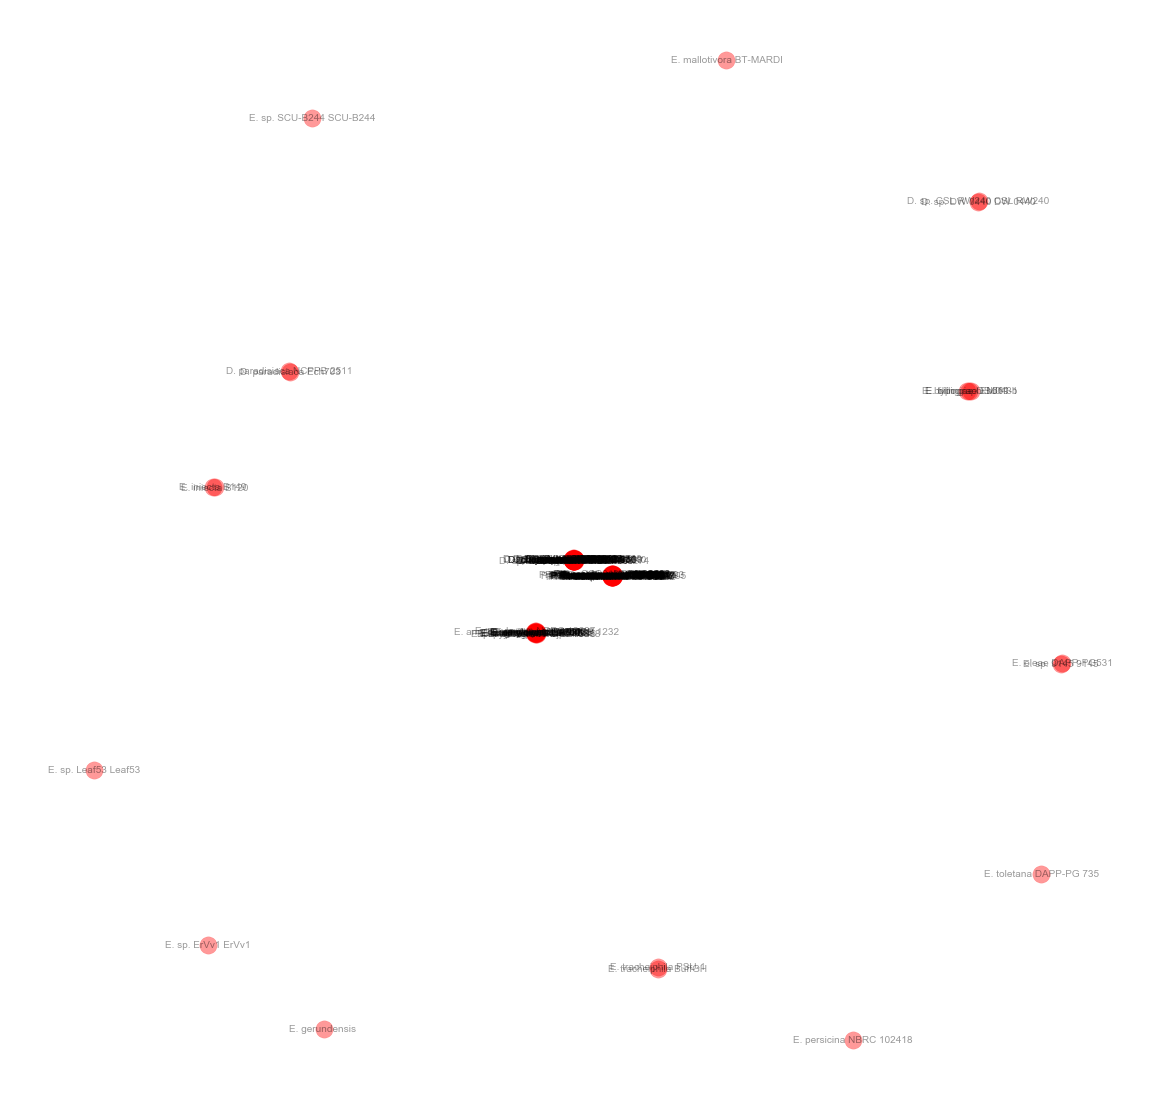

In [8]:
fig = figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)

# Try different weightings
weight = 'identity'
#weight = 'logident'
#weight = 'difference'

# Try different layouts
layout = nx.spring_layout(G, weight=weight, k=0.125, iterations=800)
#layout = nx.circular_layout(G)
#layout = nx.random_layout(G)
#layout = nx.shell_layout(G)
#layout = nx.spectral_layout(G, weight=weight, scale=2)

# Render
nx.draw(G, pos=layout, ax=ax, with_labels=True, labels=labeldict,
        alpha=0.4, font_size=10, edge_color="#cccccc")

### Functions to draw networks

In [9]:
def draw_network(graph, weight='identity', k=0.125, iterations=800, figsize=(20, 20)):
    fig, ax = subplots(figsize=figsize)
    layout = nx.spring_layout(graph, weight=weight, k=k, iterations=iterations)
    labels = {key: val for (key, val) in labeldict.items() if key in graph.nodes()}
    nx.draw(graph, pos=layout, ax=ax, with_labels=True, labels=labels,
            alpha=0.4, font_size=10, edge_color="#cccccc")

## Identifying natural groupings of isolates

By looking at the sizes of the connected component subgraphs (i.e. the individual disjoint graphs in the network) we can see how many different 'broad' classifications are supported by the data.

In [11]:
for SG in nx.connected_component_subgraphs(G):
    print("{0}\n{1}\n\n".format(len(SG.nodes()),
                                [labeldict[n] if n in labeldict else n
                                 for n in SG.nodes()]))

46
['D. solani RNS 08.23.3.1.A', 'D. solani RNS 05.1.2A', 'D. zeae EC1', 'D. solani IPO 2222', 'D. zeae ZJU1202', 'D. solani IFB 0099', 'D. chrysanthemi NCPPB 3533', 'D. dadantii NCPPB 2976', 'D. zeae NCPPB 3531', 'D. sp. B16 B16', 'D. solani M005', 'D. zeae MK19', 'D. dadantii 3937', 'D. dianthicola NCPPB 453', 'D. solani IPO 2222', 'D. solani MK16', 'D. solani RNS 07.7.3B', 'D. dianthicola RNS04.9', 'D. solani PPO 9019', 'D. dianthicola GBBC 2039', 'D. solani MK10', 'D. zeae NCPPB 3532', 'D. zeae DZ2Q', 'D. zeae MS1', 'D. dadantii NCPPB 898', 'D. chrysanthemi M074', 'D. chrysanthemi NCPPB 402', 'D. sp. CSL RW240 CSL RW240', 'D. dianthicola NCPPB 3534', 'D. chrysanthemi NCPPB 516', 'D. dianthicola NCPPB 3534', 'D. solani D s0432-1', 'D. sp. MK7 MK7', 'D. sp. NCPPB 3274 NCPPB 3274', 'D. chrysanthemi Ech1591', 'D. zeae Ech586', 'D. dianthicola IPO 980', 'D. chrysanthemi L11', 'D. solani PPO 9134', 'D. zeae NCPPB 2538', 'D. dadantii NCPPB 3537', 'D. sp. S1 S1', 'D. sp. 2B12 2B12', 'D. so

*Cliques* are completely-connected subgraphs, and represent internal groupings of isolates.

In [12]:
cliques = list(nx.find_cliques(G))
for c in cliques:
    print("{0}\n{1}\n\n".format(len(c),
                                [labeldict[n] if n in labeldict else n
                                 for n in c]))

57
['P. carotovorum YC D65', 'P. carotovorum PC1', 'P. carotovorum BC S2', 'P. carotovorum CFIA1033', 'P. carotovorum CFIA1001', 'P. atrosepticum NCPPB 3404', 'P. carotovorum ICMP 5702', 'P. carotovorum YC D60', 'P. wasabiae WPP163', 'P. carotovorum NCPPB 3839', 'P. wasabiae RNS08.42.1A', 'P. atrosepticum CFBP 6276', 'P. carotovorum NCPPB3841', 'P. carotovorum YC D52', 'GCA_000808295.1_ASM80829v1_genomic', 'P. wasabiae NCPPB 3701', 'P. carotovorum YC D57', 'P. carotovorum BC D6', 'P. carotovorum M022', 'P. betavasculorum NCPPB 2795', 'P. atrosepticum SCRI1043', 'P. carotovorum WPP14', 'P. carotovorum BC T2', 'P. betavasculorum NCPPB 2793', 'P. carotovorum YC D64', 'P. carotovorum BD255', 'P. carotovorum PBR1692', 'P. carotovorum KKH3', 'P. carotovorum BC T5', 'P. wasabiae CFIA1002', 'P. carotovorum LMG 21372', 'P. atrosepticum ICMP 1526', 'GCA_000291725.1_PecWas1.0_genomic', 'P. carotovorum ICMP 19477', 'P. carotovorum YC D62', 'P. carotovorum YC T39', 'P. carotovorum UGC32', 'P. carot

If the total size of the cliques is equal to the total number of nodes in the network, then we have a self-consistent classification of isolates into mutually-supporting groups.

In [13]:
print("Network size: {0}, Number of cliques: {1}, Total clique size: {2}".format(len(G),
                                                                                 len(cliques),
                                                                                 sum([len(c) for c in cliques])))

Network size: 143, Number of cliques: 17, Total clique size: 144


It is possible that one or more nodes may participate in one or more cliques. The biological interpretation of this is as yet unclear, but it might indicate that there is a significant chimeric property/LGT between two or more subgroups of isolates.

There is an interesting property of this clique-based classification. Once a clique is identified then, so long as the genome iteself is not modified (e.g. draft assembly completed), the clique is *permanent*. The addition of new genomes/sequences can only extend the clique, not replace it. Cliques can then be considered as intersecting surfaces, where the clique defines the surface, and individual organisms present in several cliques represent *intersections* between those surfaces. Multiple surfaces may intersect at the same point.

For a set of genomes, with a given coverage/identity threshold, the difference between the number of nodes, and the total size of cliques, is reflective of the number of intersections, and may inidicate recombination, or that the classification does not fall along *natural boundaries* in the data. This suggests an approach where the total clique size can be inspected as one or more thresholds increases, and fluctuations observed: *minima* on this path indicate natural groupings of the genomes.

I may have a mathematical answer for David Baltrus' suggestion of a universal whole genome classification scheme.

### Functions for identification of cliques/subgraphs

In [14]:
def count_cliques(graph):
    cliques = list(nx.find_cliques(graph))
    clique_size = sum([len(c) for c in cliques])
    subgraphs = list(nx.connected_component_subgraphs(graph))
    return(len(graph), len(subgraphs), len(cliques), clique_size)

def print_cliques(graph):
    cliques = list(nx.find_cliques(graph))
    print("Network size: {0}, Subgraphs: {1}, Number of cliques: {2}, Total clique size: {3}".format(*count_cliques(graph)))
    for c in cliques:
        print("{0}\n{1}\n\n".format(len(c),
                                    [labeldict[n] if n in labeldict else n
                                     for n in c]))
        


### Increasing thresholds

What happens if we increase the requirement for percentage coverage to be greater than 90% of the total genome length?

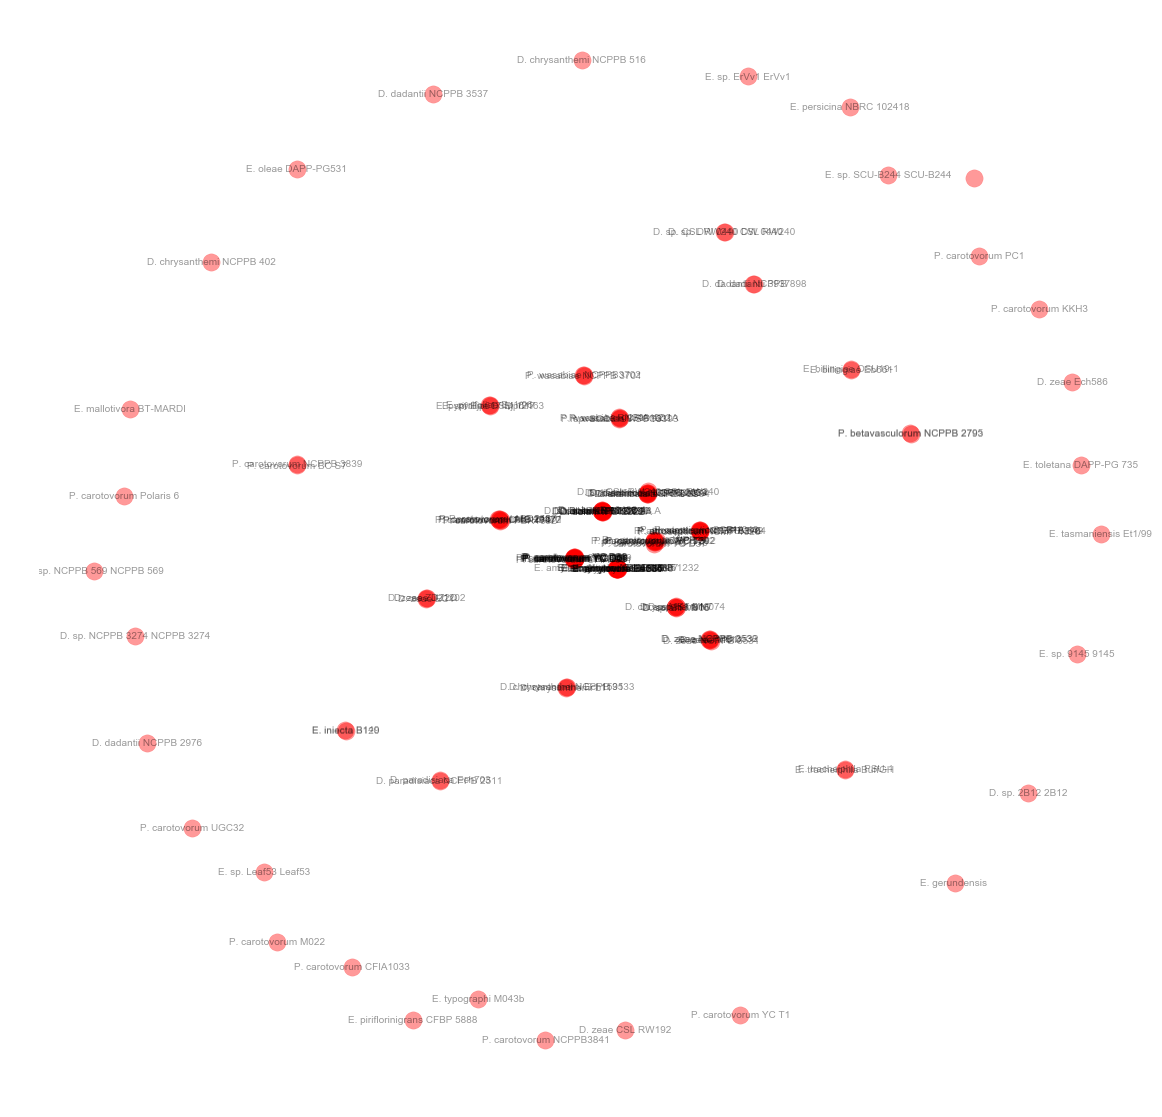

In [15]:
# Create graph
H = nx.Graph()

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    H.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(H,), cov_thresh=0.9)

# Draw network
fig, ax = subplots(figsize=(20,20))
layout = nx.spring_layout(H, weight=weight, k=0.025, iterations=800)
nx.draw(H, pos=layout, ax=ax, with_labels=True, labels=labeldict, alpha=0.4, font_size=10, edge_color="#cccccc")

Looking at the graph, we can see that there is separation into subgraphs that appear to correspond to natural species groupings.

In [16]:
print_cliques(H)

Network size: 143, Subgraphs: 52, Number of cliques: 76, Total clique size: 247
2
['P. carotovorum NCPPB 3839', 'P. carotovorum BC S7']


6
['D. dianthicola RNS04.9', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 3534', 'D. dianthicola GBBC 2039', 'D. dianthicola NCPPB 3534', 'D. dianthicola NCPPB 453']


2
['E. billingiae Eb661', 'E. billingiae OSU19-1']


1
['D. zeae Ech586']


6
['P. atrosepticum SCRI1043', 'P. atrosepticum 21A', 'P. atrosepticum NCPPB 3404', 'GCA_000696465.1_ASM69646v1_genomic', 'P. atrosepticum NCPPB 549', 'P. atrosepticum CFBP 6276']


5
['P. carotovorum PBR1692', 'P. carotovorum BD255', 'P. carotovorum LMG 21372', 'P. carotovorum PcbHPI01', 'P. carotovorum LMG 21371']


3
['P. carotovorum LMG 21372', 'P. carotovorum BD255', 'P. carotovorum ICMP 19477']


12
['D. solani GBBC 2040', 'D. solani PPO 9134', 'D. solani RNS 05.1.2A', 'D. solani RNS 07.7.3B', 'D. solani MK10', 'D. solani RNS 08.23.3.1.A', 'D. solani IPO 2222', 'D. solani D s0432-1', 'D. solani IFB 009

Inspection of the cliques at this threshold however shows that there's quite a bit of confusion within those groupings, that stems from the different edge weights - not all the internal groupings are equally well-connected. 

What happens if we require that percentage identity also needs to be over 99%?

In [17]:
# Remove edges from the network if percentage identity is less than 99%
edgelist = H.edges(data='identity')
for e in edgelist:
    if e[-1] < 0.95:
        H.remove_edge(e[0], e[1])

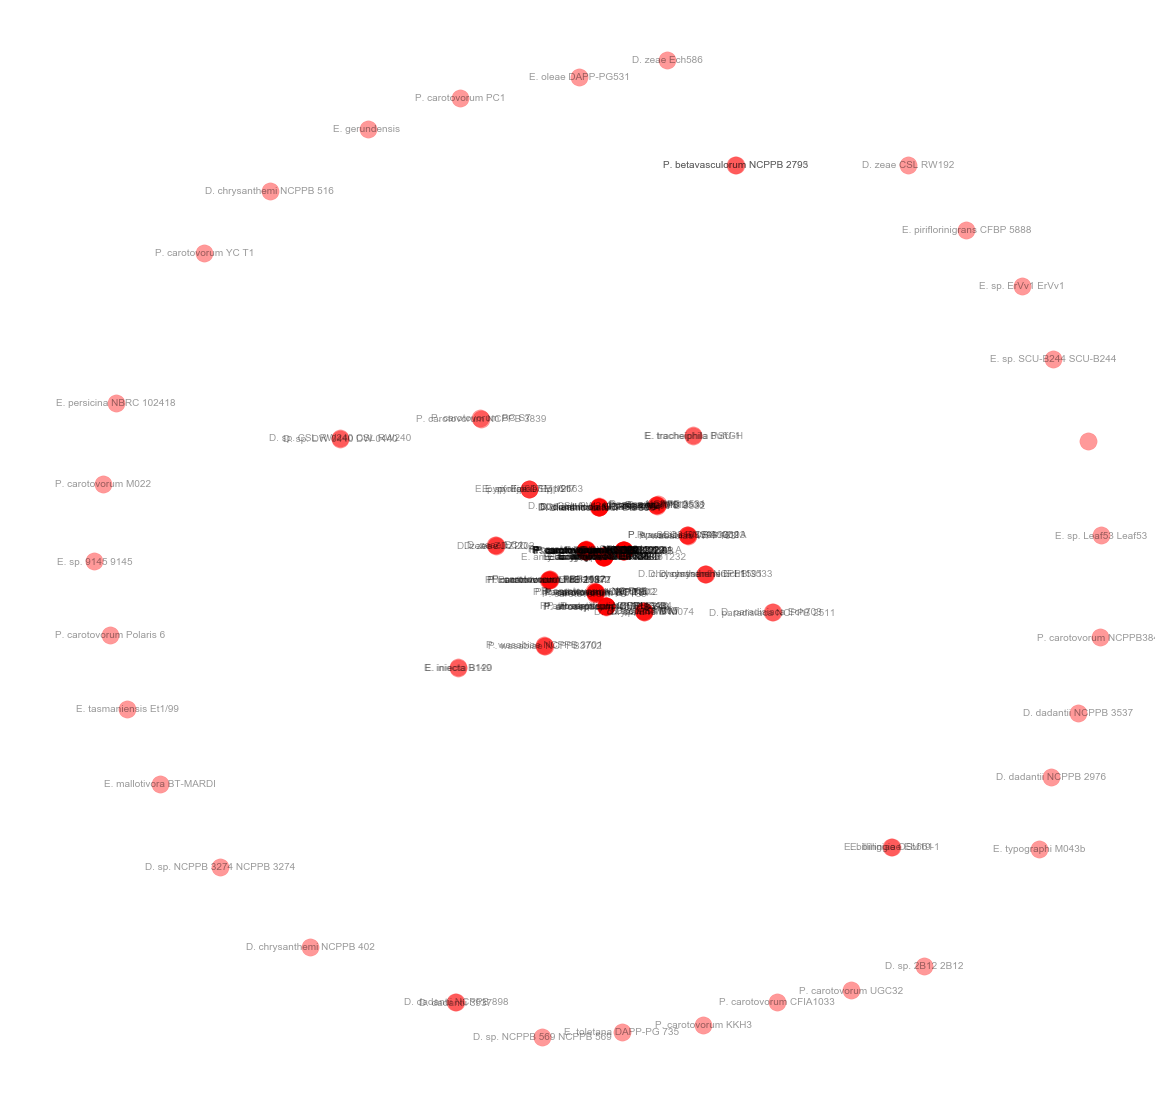

In [18]:
draw_network(H, k=0.05)

In [19]:
print_cliques(H)

Network size: 143, Subgraphs: 52, Number of cliques: 76, Total clique size: 247
2
['P. carotovorum NCPPB 3839', 'P. carotovorum BC S7']


6
['D. dianthicola RNS04.9', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 3534', 'D. dianthicola GBBC 2039', 'D. dianthicola NCPPB 3534', 'D. dianthicola NCPPB 453']


2
['E. billingiae Eb661', 'E. billingiae OSU19-1']


1
['D. zeae Ech586']


6
['P. atrosepticum SCRI1043', 'P. atrosepticum 21A', 'P. atrosepticum NCPPB 3404', 'GCA_000696465.1_ASM69646v1_genomic', 'P. atrosepticum NCPPB 549', 'P. atrosepticum CFBP 6276']


5
['P. carotovorum PBR1692', 'P. carotovorum BD255', 'P. carotovorum LMG 21372', 'P. carotovorum PcbHPI01', 'P. carotovorum LMG 21371']


3
['P. carotovorum LMG 21372', 'P. carotovorum BD255', 'P. carotovorum ICMP 19477']


12
['D. solani GBBC 2040', 'D. solani PPO 9134', 'D. solani RNS 05.1.2A', 'D. solani RNS 07.7.3B', 'D. solani MK10', 'D. solani RNS 08.23.3.1.A', 'D. solani IPO 2222', 'D. solani D s0432-1', 'D. solani IFB 009

There seems to have been no change. So what if we increase to 99.9% identity threshold?

In [20]:
edgelist = H.edges(data='identity')
for e in edgelist:
    if e[-1] < 0.999:
        H.remove_edge(e[0], e[1])

RuntimeError: dictionary changed size during iteration

In [ ]:
draw_network(H, k=0.05)

In [ ]:
print_cliques(H)

There's a great deal of fragmentation of the network - 110 subgraphs, with lots of singletons.

### Functions to check thresholds

In [30]:
def trim_graph(graph, threshold, data='identity'):
    edgelist = graph.edges(data=data)
    for e in list(edgelist):
        if e[-1] < threshold:
            graph.remove_edge(e[0], e[1])
    return(graph)

In [31]:
len(G.edges())

2828

### Change %identity threshold and watch clique size

What happens to the difference between total clique size and network size, as we increase %identity threshold?

In [32]:
# Create graph
J = nx.Graph()

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    J.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(J,), cov_thresh=0.5)

# Loop over thresholds from 0 to 100% identity, get difference in size
# We could increment through the observed thresholds in the graph, but
# even for this example, a resolution of 1500 points between 0.85 and
# 1 is quicker (though not quick!)
thresholds = linspace(0.85, 1, 1500)
row_list = []
for t in thresholds:
    J = trim_graph(J, t)
    netsize, sgsize, clqcount, clqsize = count_cliques(J)
    datadict = {'identity': t,
                'network_size': netsize,
                'subgraph_count': sgsize,
                'clique_count': clqcount,
                'total_clique_size': clqsize,
                'difference': clqsize-netsize}
    row_list.append(datadict)
threshold_profile = pd.DataFrame(row_list, columns=['identity', 'network_size',
                                                    'subgraph_count',
                                                    'clique_count', 'total_clique_size',
                                                    'difference'])

In [33]:
# Check the data looks sane
threshold_profile.head()

,identity,network_size,subgraph_count,clique_count,total_clique_size,difference
0,0.8500,143,16,17,144,1
1,0.8501,143,16,17,144,1
2,0.8502,143,16,17,144,1
3,0.8503,143,16,17,144,1
4,0.8504,143,16,17,144,1


#### Excess isolates in cliques

The excess of total number of isolates in cliques over the total number of isolates represents the count of isolates that are at *edges* or *intersections* between groups. A large excess indicates a difficulty in classifying those isolates uniquely. An excess of zero (or nearly zero) indicates that each isolate can be placed in exactly one mutually-supporting group, and may represent a natural clustering threshold for the dataset.

(0.85, 1)

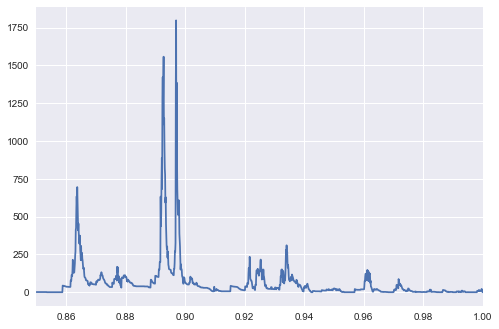

In [34]:
plot(threshold_profile['identity'], threshold_profile['difference'])
xlim(0.85, 1)

From the plot we see three major, and around eight minor peaks. The largest peaks are just short of 90% identity, and around 86% identity. There are smaller peaks at 92, 93 and 96% identity. It is tempting to see the peaks as indicating identity thresholds where there is much classification confusion.

It could be that the larger peaks indicate confusion at allocating distinct species or genus boundaries. The smaller peaks indicate confusion at allocating species or 'subspecies' boundaries.

There are noticable minima at around 91%, 95% and 98% identity. These may represent natural boundary minima that separate out genus and species well.

(0, 800)

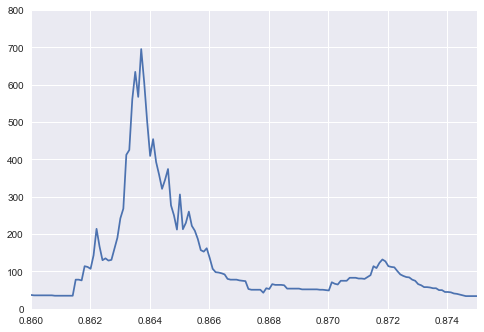

In [35]:
# The first large peak
plot(threshold_profile['identity'], threshold_profile['difference'])
xlim(0.86, 0.875)
ylim(0, 800)

Looking at the 0.864 peak:

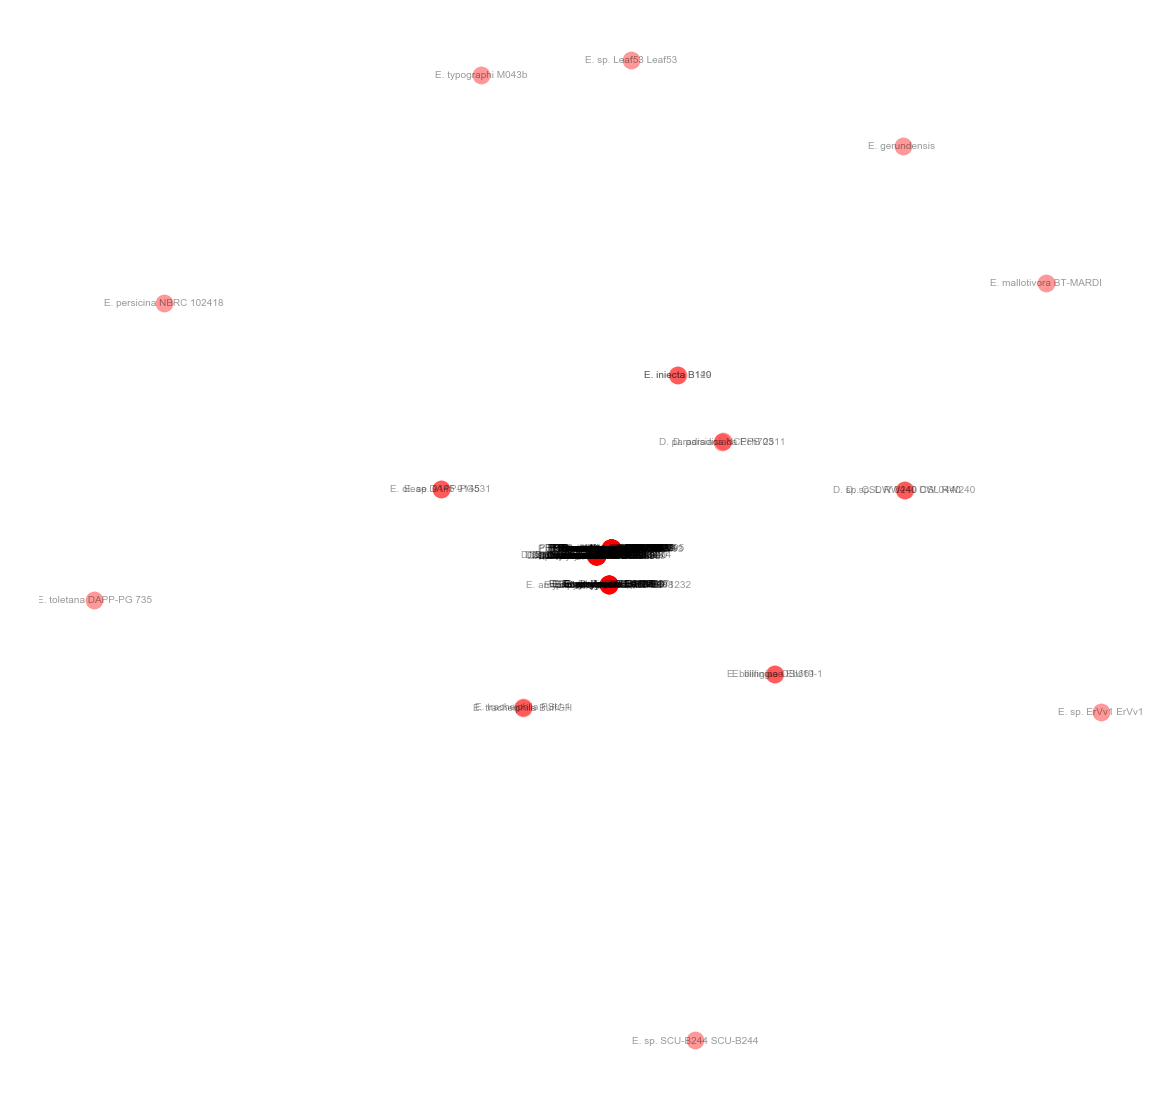

In [36]:
# Create graph
K = nx.Graph()

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    K.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(K,), cov_thresh=0.5)

# Trim to 0.864% identity
K = trim_graph(K, 0.864)

# Draw network
draw_network(K, k=0.05)

In [24]:
# What are the cliques?
print_cliques(K)

NameError: name 'K' is not defined

The graph and list of cliques indicate that the genus-level separation is good, but there are a large number of cliques within those clusters that apparently do not separate well between assigned species - mostly within *Dickeya*.

Moving up to the next minimum, at about 0.868:

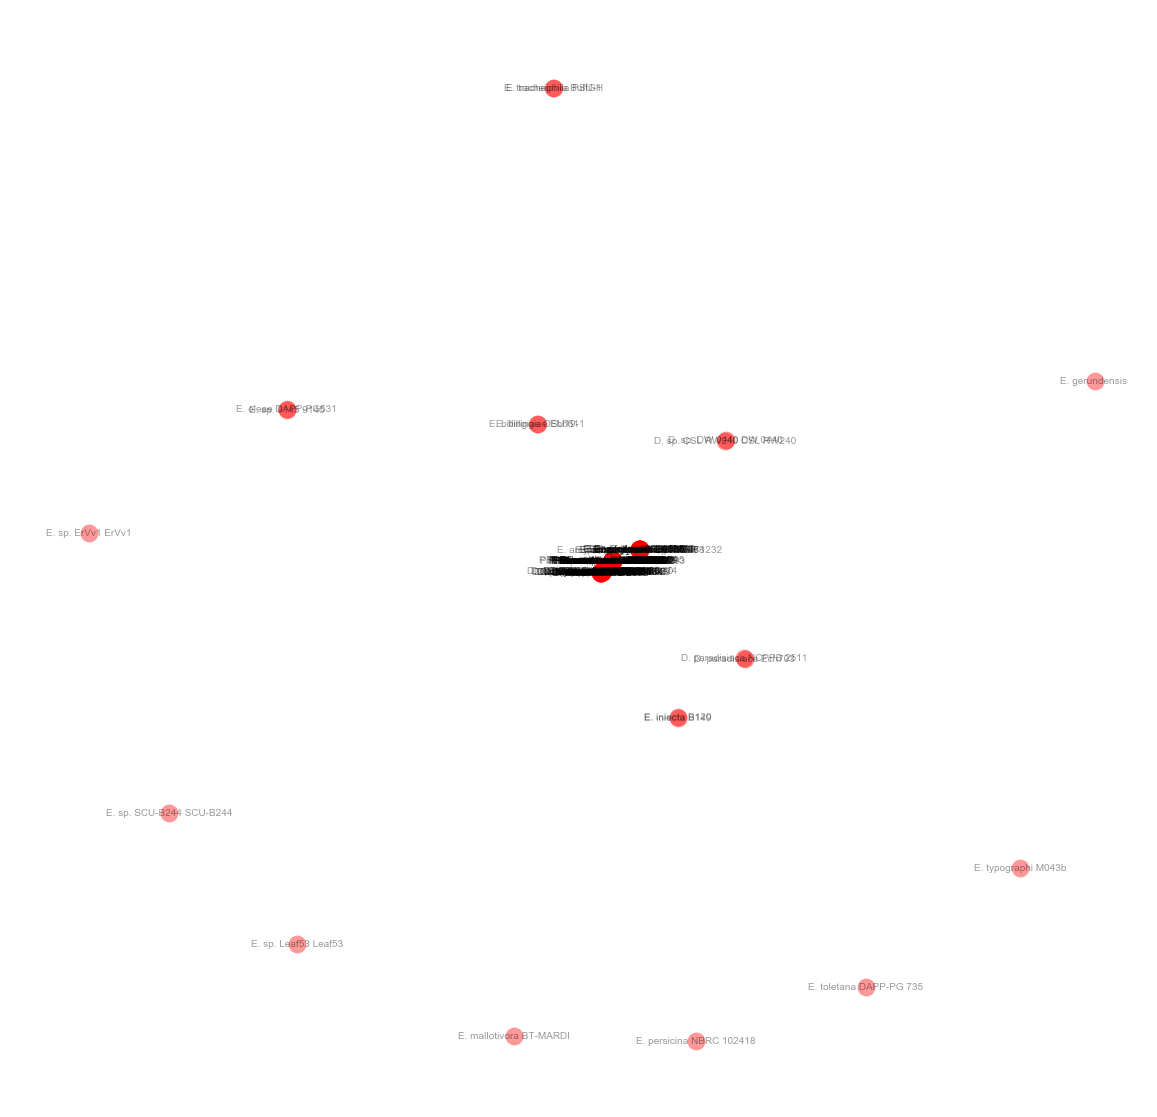

In [38]:
# Trim to 0.868% identity
K = trim_graph(K, 0.868)

# Draw network
draw_network(K, k=0.05)

In [39]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 17, Number of cliques: 21, Total clique size: 196
57
['P. carotovorum YC D65', 'P. carotovorum PC1', 'P. carotovorum BC S2', 'P. carotovorum CFIA1033', 'P. carotovorum CFIA1001', 'P. atrosepticum NCPPB 3404', 'P. carotovorum ICMP 5702', 'P. carotovorum YC D60', 'P. wasabiae WPP163', 'P. carotovorum NCPPB 3839', 'P. wasabiae RNS08.42.1A', 'P. atrosepticum CFBP 6276', 'P. carotovorum NCPPB3841', 'P. carotovorum YC D52', 'GCA_000808295.1_ASM80829v1_genomic', 'P. wasabiae NCPPB 3701', 'P. carotovorum YC D57', 'P. carotovorum BC D6', 'P. carotovorum M022', 'P. betavasculorum NCPPB 2795', 'P. atrosepticum SCRI1043', 'P. carotovorum WPP14', 'P. carotovorum BC T2', 'P. betavasculorum NCPPB 2793', 'P. carotovorum YC D64', 'P. carotovorum BD255', 'P. carotovorum PBR1692', 'P. carotovorum KKH3', 'P. carotovorum BC T5', 'P. wasabiae CFIA1002', 'P. carotovorum LMG 21372', 'P. atrosepticum ICMP 1526', 'GCA_000291725.1_PecWas1.0_genomic', 'P. carotovorum ICMP 19477', 'P.

Now there are fewer cliques, especially for *Dickeya*, which appears to have settled out at a *Dch/Dze*:other *Dickeya* split, with some lingering connecting edges - apparent both from the graph and the clique list.

The really big peak is at around 0.893% identity, with the next minimum at around 0.914%

(0, 2000)

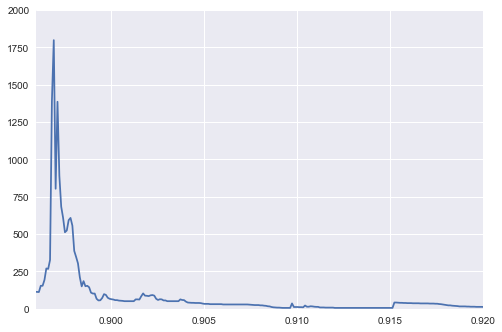

In [40]:
# The largest peak
plot(threshold_profile['identity'], threshold_profile['difference'])
xlim(0.896, 0.92)
ylim(0, 2000)

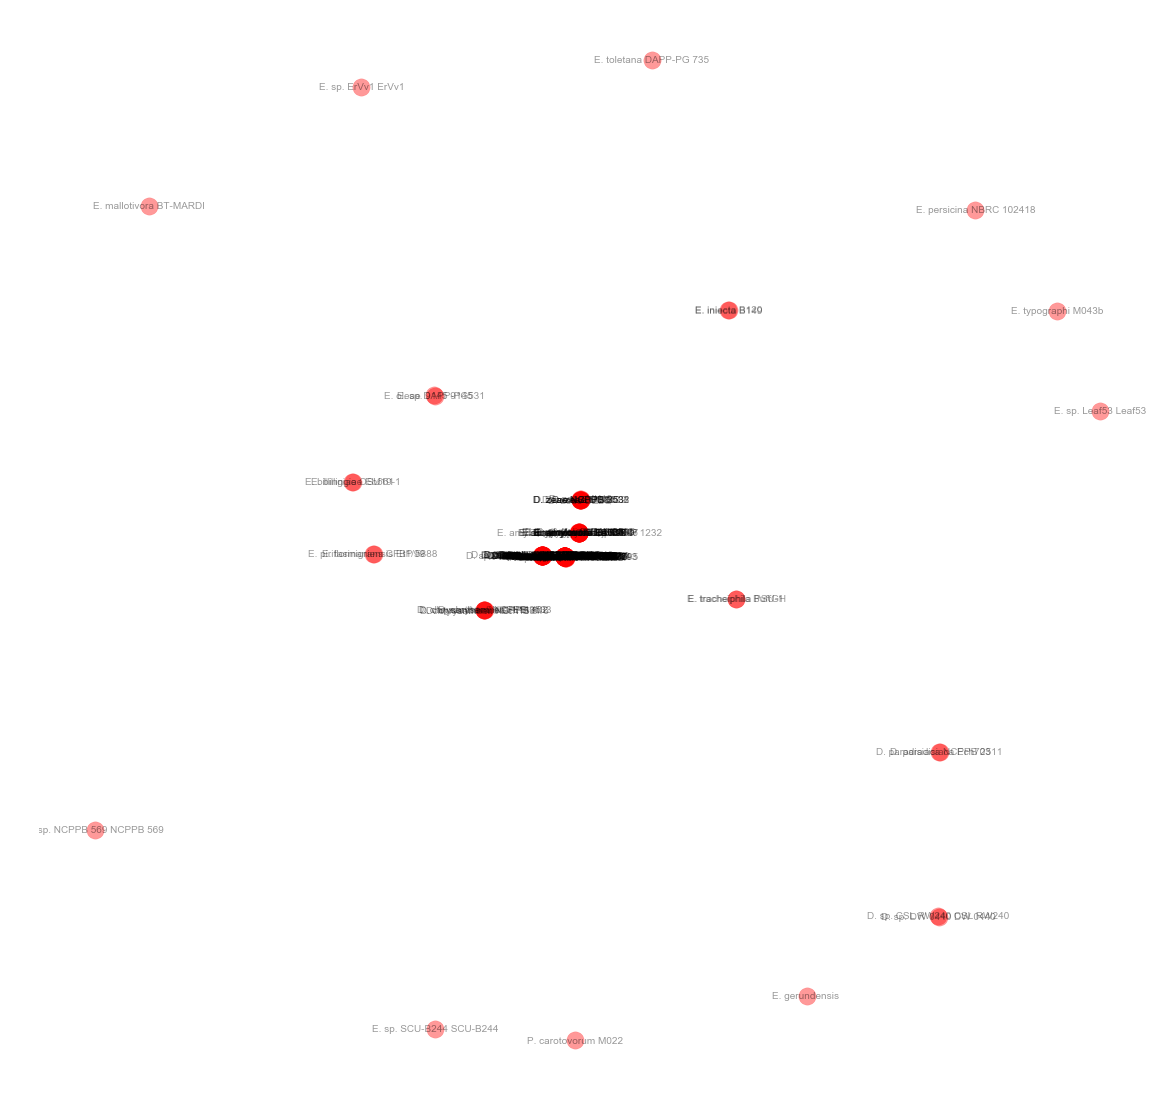

In [41]:
# Trim to 0.896% identity
K = trim_graph(K, 0.8966)

# Draw network
draw_network(K, k=0.05)

In [43]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 27, Number of cliques: 28, Total clique size: 149
38
['P. carotovorum YC D65', 'P. carotovorum BC S2', 'P. carotovorum CFIA1033', 'P. carotovorum CFIA1001', 'P. carotovorum ICMP 5702', 'P. carotovorum YC D60', 'P. carotovorum NCPPB 3839', 'P. carotovorum NCPPB3841', 'P. carotovorum YC D52', 'GCA_000808295.1_ASM80829v1_genomic', 'P. carotovorum YC D57', 'P. carotovorum BC D6', 'P. carotovorum WPP14', 'P. carotovorum BC T2', 'P. carotovorum YC D64', 'P. carotovorum BD255', 'P. carotovorum PBR1692', 'P. carotovorum KKH3', 'P. carotovorum PCC21', 'P. carotovorum YC T1', 'P. carotovorum Polaris 6', 'P. carotovorum YC D29', 'P. carotovorum LMG 21371', 'P. carotovorum BC T5', 'P. carotovorum LMG 21372', 'P. carotovorum ICMP 19477', 'P. carotovorum YC D62', 'P. carotovorum YC T39', 'P. carotovorum YC D21', 'GCA_000749915.1_ASM74991v1_genomic', 'P. carotovorum NCPPB 312', 'P. carotovorum YC D49', 'P. carotovorum PcbHPI01', 'P. carotovorum YC T3', 'P. carotovorum YC

At the large peak, we seem to have hit a threshold of indecision for *Pectobacterium* spp. - which seem to take up most of the overlapping cliques. *P. wasabiae* looks to be well split-off from the the other *Pectobacteria*, but there's quite a bit of confusion among the other species.

At the next minimum:

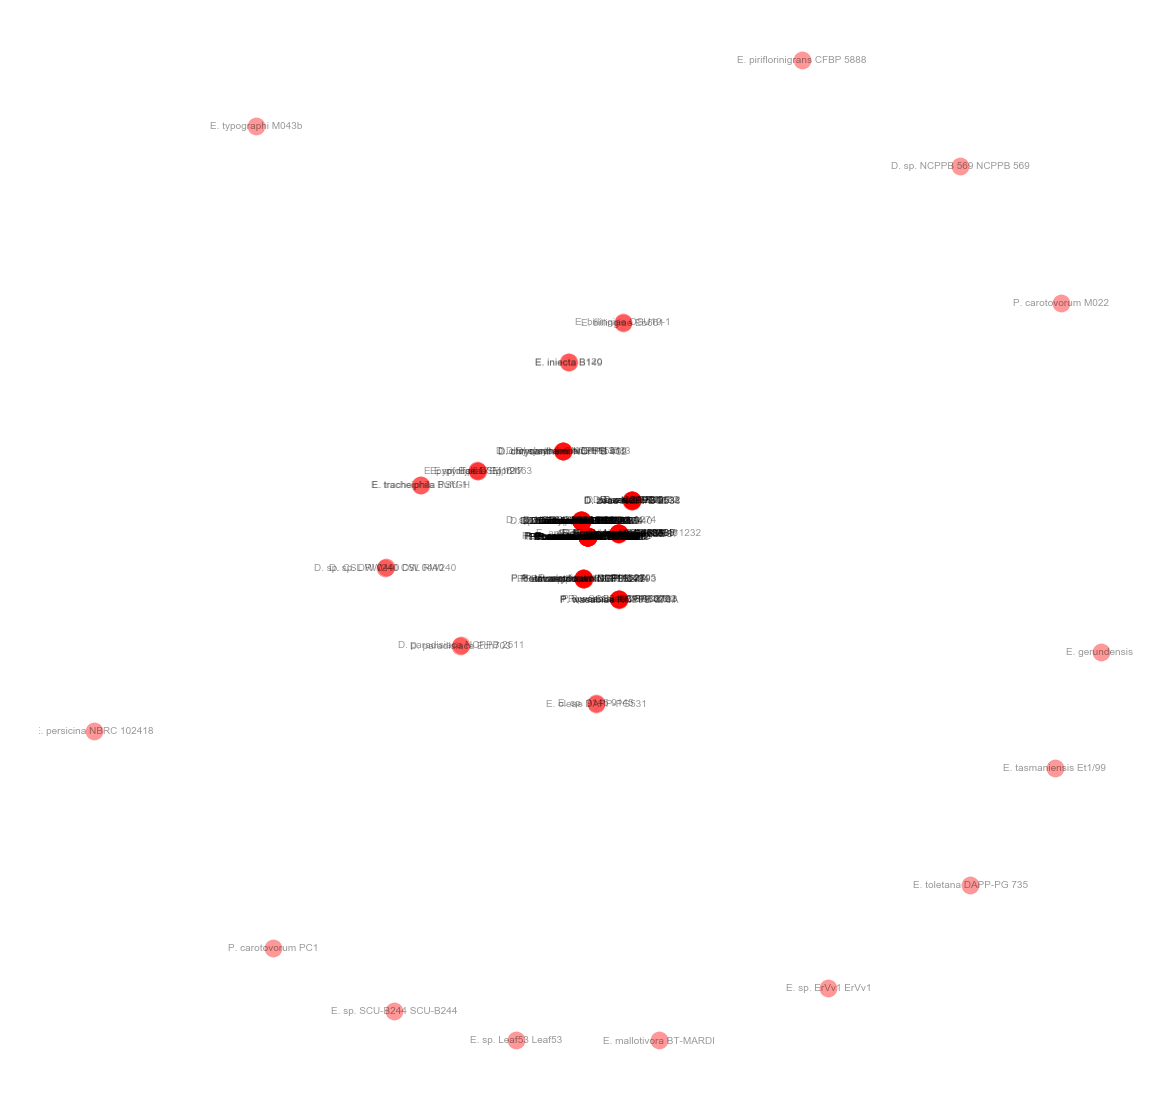

In [44]:
# Trim to 0.914% identity
K = trim_graph(K, 0.914)

# Draw network
draw_network(K, k=0.05)

In [45]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 27, Number of cliques: 28, Total clique size: 149
38
['P. carotovorum YC D65', 'P. carotovorum BC S2', 'P. carotovorum CFIA1033', 'P. carotovorum CFIA1001', 'P. carotovorum ICMP 5702', 'P. carotovorum YC D60', 'P. carotovorum NCPPB 3839', 'P. carotovorum NCPPB3841', 'P. carotovorum YC D52', 'GCA_000808295.1_ASM80829v1_genomic', 'P. carotovorum YC D57', 'P. carotovorum BC D6', 'P. carotovorum WPP14', 'P. carotovorum BC T2', 'P. carotovorum YC D64', 'P. carotovorum BD255', 'P. carotovorum PBR1692', 'P. carotovorum KKH3', 'P. carotovorum PCC21', 'P. carotovorum YC T1', 'P. carotovorum Polaris 6', 'P. carotovorum YC D29', 'P. carotovorum LMG 21371', 'P. carotovorum BC T5', 'P. carotovorum LMG 21372', 'P. carotovorum ICMP 19477', 'P. carotovorum YC D62', 'P. carotovorum YC T39', 'P. carotovorum YC D21', 'GCA_000749915.1_ASM74991v1_genomic', 'P. carotovorum NCPPB 312', 'P. carotovorum YC D49', 'P. carotovorum PcbHPI01', 'P. carotovorum YC T3', 'P. carotovorum YC

There is only a small amount of confusion - the isolates are well-separated into groups, but not in a way that matches the assigned species names (for the most part). Some species are well separated into cliques, such as:

* *P. carotovorum*
* *E. amylovora*
* *D. zeae*
* *P. wasabiae*
* *D. chrysanthemi*
* *D. paradisiaca*

but, at this point, most *Dickeya* spp. are still lumped together, and there's not clear disconnection between *P. betavasculorum* and *P. atrosepticum*.

Moving on to one of the later peaks, at 93.4% identity, with corresponding minimum at 0.955:

(0, 350)

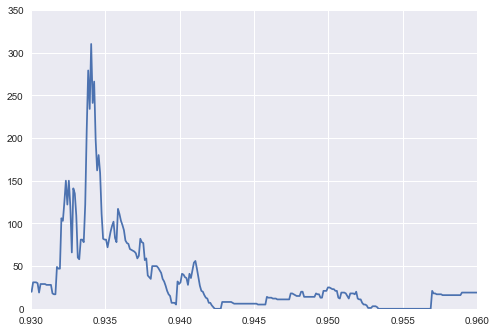

In [46]:
# A species boundary peak?
plot(threshold_profile['identity'], threshold_profile['difference'])
xlim(0.93, 0.96)
ylim(0, 350)

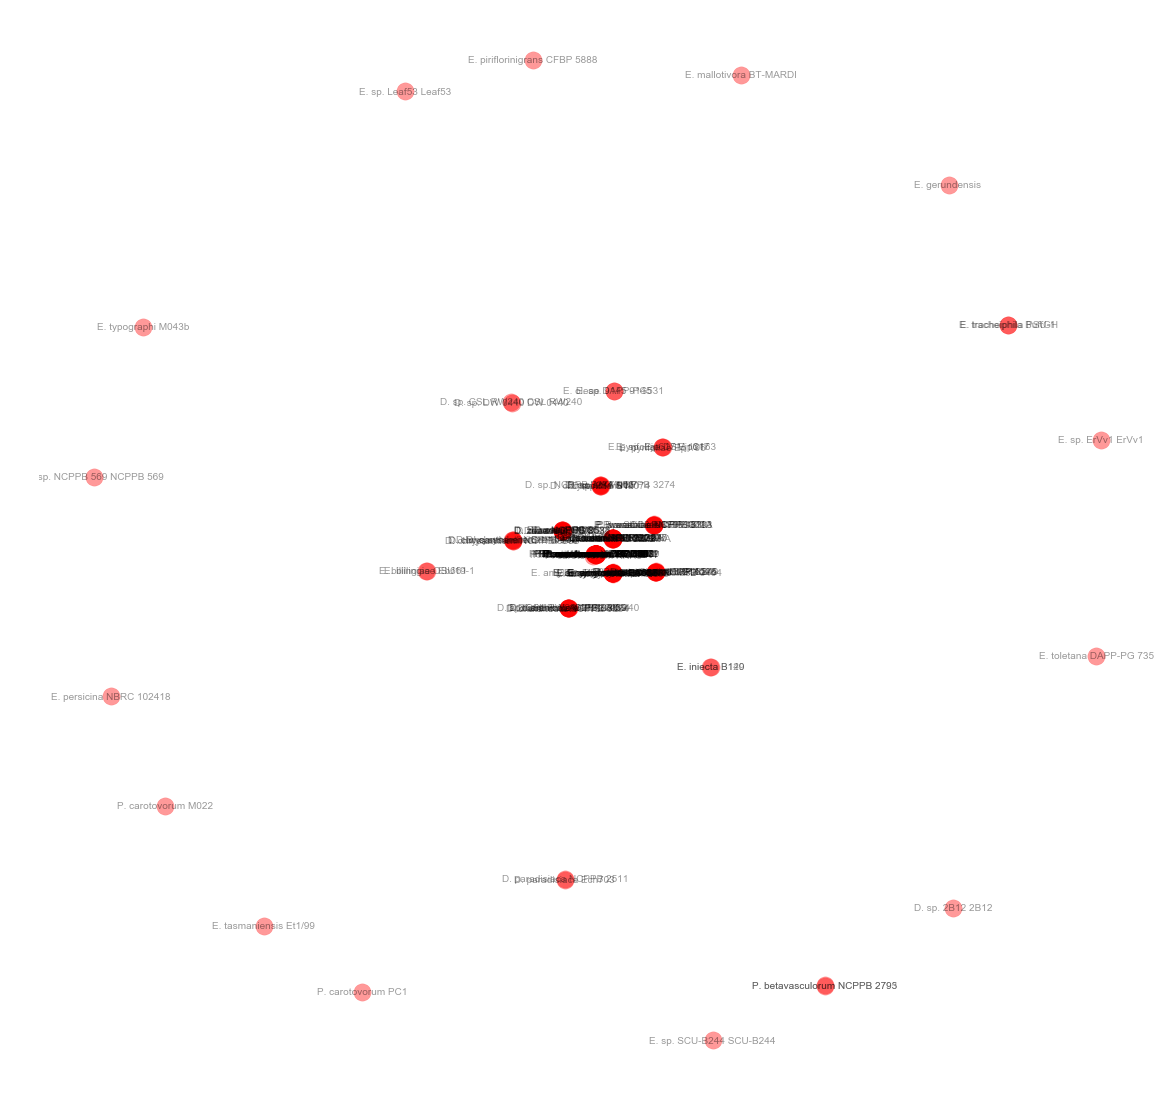

In [47]:
# Trim to 0.934 identity
K = trim_graph(K, 0.934)

# Draw network
draw_network(K, k=0.05)

In [48]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 31, Number of cliques: 49, Total clique size: 455
7
['P. wasabiae WPP163', 'P. sp. SCC3193 SCC3193', 'P. wasabiae CFIA1002', 'P. wasabiae RNS08.42.1A', 'P. wasabiae NCPPB 3701', 'P. wasabiae NCPPB3702', 'GCA_000291725.1_PecWas1.0_genomic']


7
['D. dianthicola RNS04.9', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 3534', 'D. dianthicola GBBC 2039', 'D. sp. CSL RW240 CSL RW240', 'D. dianthicola NCPPB 3534', 'D. dianthicola NCPPB 453']


2
['E. billingiae Eb661', 'E. billingiae OSU19-1']


16
['D. solani RNS 08.23.3.1.A', 'D. solani PPO 9134', 'D. solani RNS 05.1.2A', 'D. solani RNS 07.7.3B', 'D. solani MK10', 'D. dadantii 3937', 'D. solani GBBC 2040', 'D. dadantii NCPPB 898', 'D. dadantii NCPPB 3537', 'D. solani IPO 2222', 'D. solani D s0432-1', 'D. solani IPO 2222', 'D. solani IFB 0099', 'D. solani MK16', 'D. solani PPO 9019', 'D. dadantii NCPPB 2976']


10
['D. zeae Ech586', 'D. zeae MS1', 'D. zeae ZJU1202', 'D. zeae NCPPB 2538', 'D. zeae DZ2Q', 'D. ze

We still have the large genus-level groupings, but now there are several points of confusion within the *P. carotovorum* cluster, leading to several cliques with overlapping membership. 

As we approach the minimum at 0.955:

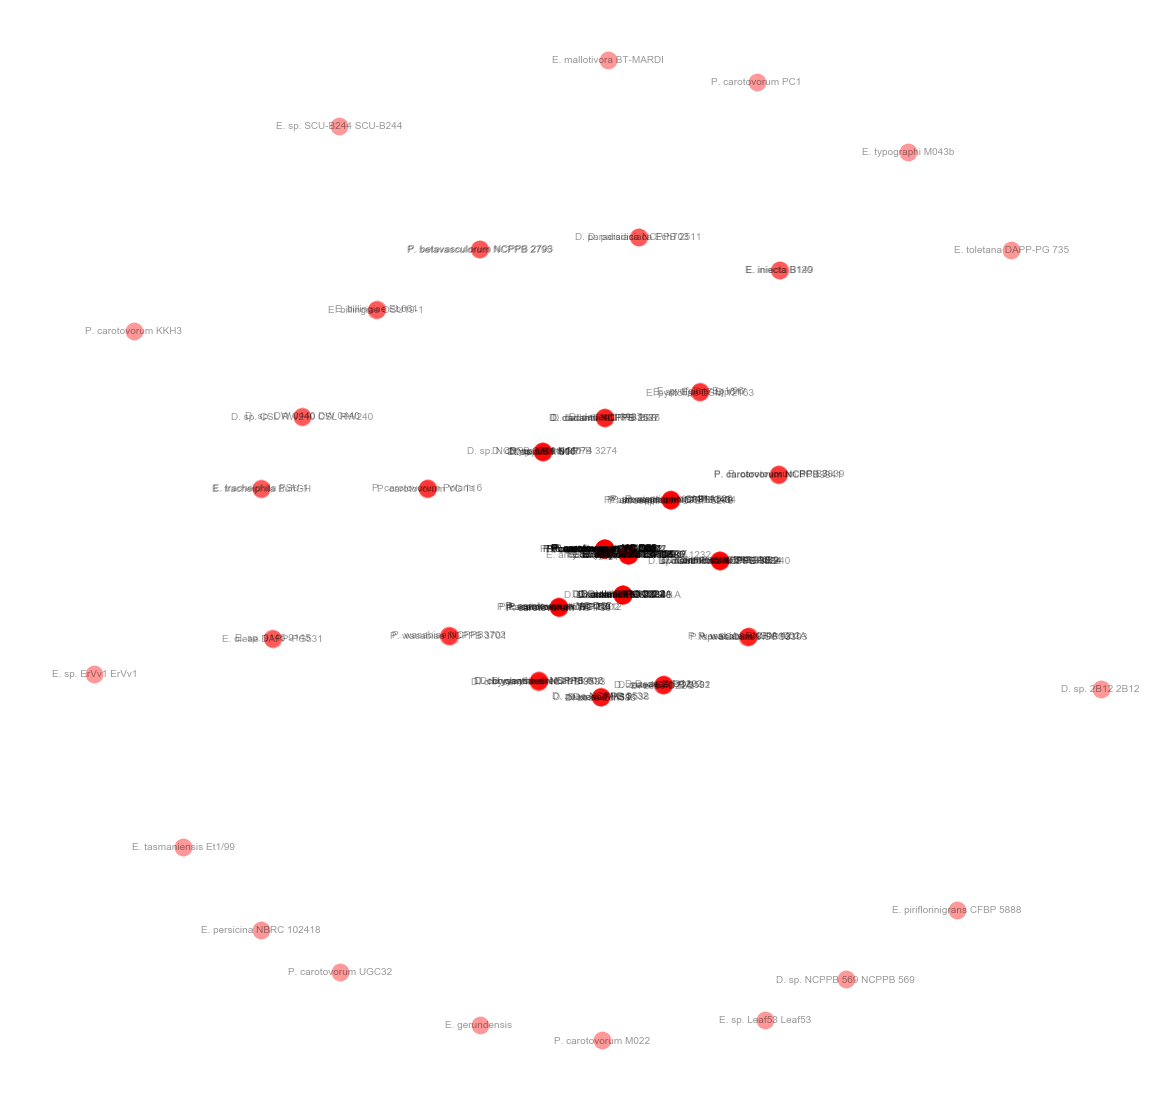

In [49]:
# Trim to 0.955 identity
K = trim_graph(K, 0.955)

# Draw network
draw_network(K, k=0.025)

In [50]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 39, Number of cliques: 39, Total clique size: 143
23
['P. carotovorum YC D65', 'P. carotovorum BC S2', 'P. carotovorum CFIA1033', 'P. carotovorum PCC21', 'P. carotovorum YC D52', 'P. carotovorum LMG 21371', 'P. carotovorum YC D64', 'P. carotovorum YC D29', 'P. carotovorum BD255', 'P. carotovorum PBR1692', 'GCA_000808295.1_ASM80829v1_genomic', 'P. carotovorum LMG 21372', 'P. carotovorum ICMP 19477', 'P. carotovorum YC D62', 'P. carotovorum CFIA1009', 'P. carotovorum YC D21', 'P. carotovorum BC D6', 'P. carotovorum YC D49', 'P. carotovorum PcbHPI01', 'P. carotovorum CFIA1001', 'P. carotovorum YC D60', 'P. carotovorum YC D46', 'P. carotovorum YC T3']


3
['P. carotovorum NCPPB 3839', 'P. carotovorum NCPPB3841', 'P. carotovorum BC S7']


7
['D. dianthicola RNS04.9', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 3534', 'D. dianthicola GBBC 2039', 'D. sp. CSL RW240 CSL RW240', 'D. dianthicola NCPPB 3534', 'D. dianthicola NCPPB 453']


2
['E. billingiae Eb661',

We have a 'perfect' assignment of isolates to cliques/subgraphs, that has split the *P. carotovorum* subgroup into five distinct mutually-supporting cliques. 

We can look at the individual subgraphs, below.

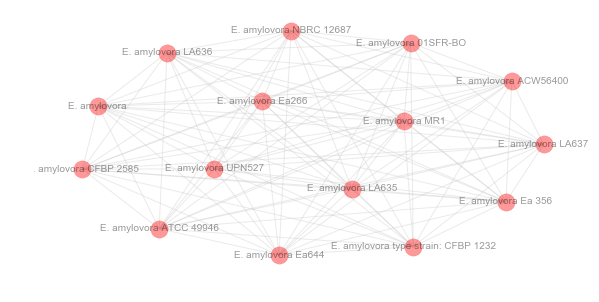

In [51]:
# Get subgraphs
subgraphs = list(nx.connected_component_subgraphs(K))

# Draw a single subgraph
draw_network(subgraphs[2], figsize=(10, 5))

## Clique count and subgraph count

Plotting the variation in clique count (as opposed to total clique members) with percentage identity, a clear trend is notable:

In [ ]:
plot(threshold_profile['identity'], threshold_profile['clique_count'])
xlim(0.85, 1)

This is a similar 'spiky' plot to the total number of clique members, but overlaid on a baseline that increases gradually at first (up to about 97% identity), and then rapidly from that point.

This baseline is, essentially, the subgraph count. As cliques cannot span subgraphs, there must be at least as many cliques as subgraphs. 

In [ ]:
plot(threshold_profile['identity'], threshold_profile['subgraph_count'])
xlim(0.85, 1)

Subtracting the subgraph count from the clique count, we get the following profile:

In [ ]:
plot(threshold_profile['identity'], threshold_profile['clique_count']-threshold_profile['subgraph_count'])
xlim(0.85, 1)
xlabel("%identity")
ylabel("confused cluster members")
title("Cluster confusion")
savefig("/Users/lpritc/Desktop/thresholds.pdf")

This gives us a second way to identify natural boundaries in the data: where do the number of cliques match the number of subgraphs? That is, at which points does the plot above touch the *x*-axis? At these points, we might think that the choice of thresholds has found natural groupings of data.

We can estimate such points by plotting a histogram of zero values in any window, and noting the locations of the peaks. As a future improvement, it should be possible to identify locations of zeros with confidence intervals, in an automated manner, by statistical inference from the data.

In [ ]:
bounds = threshold_profile.loc[threshold_profile['clique_count']-threshold_profile['subgraph_count']==0,]
n, bins, patches = hist(bounds['identity'], bins=50, normed=True)
xlim(0.85, 1)
xlabel('%identity')
ylabel('frequency')
title('Natural clusterings')
savefig("/Users/lpritc/Desktop/threshold_zeros.pdf")

In [ ]:
bounds = threshold_profile.loc[threshold_profile['clique_count']-threshold_profile['subgraph_count']==0,]
sns.kdeplot(bounds['identity'],
            bw=0.05, shade=True, legend=False, gridsize=1000)
xlim(0.85, 1)
xlabel('%identity')
title('Natural clusterings')
savefig("/Users/lpritc/Desktop/threshold_zeros_kde.pdf")

In [ ]:
help(sns.kdeplot)

This indicates that the regions of percentage identity at 0.850-0.855; 0.950-0.955; 0.965-0.970; 0.990-0.995 are likely to be natural boundaries.

We can inspect these, below.

In [ ]:
# Create graph
L = nx.Graph()

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    L.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(L,), cov_thresh=0.5)

# Trim to 0.855% identity
L = trim_graph(L, 0.855)

# Draw network
draw_network(L, k=0.05)

In [ ]:
print_cliques(L)

At this level of identity, we have a split into the major genus groups - with some of the smaller clusters of isolates and individual isolates also indicated as groups.

In [ ]:
# Trim to 0.955% identity
L = trim_graph(L, 0.955)

# Draw network
draw_network(L, k=0.05)

In [ ]:
print_cliques(L)

This level of classification closely matches the individual species as previously assigned (some necessary reclassification notwithstanding). 

In [ ]:
# Trim to 0.969% identity
L = trim_graph(L, 0.969)

# Draw network
draw_network(L, k=0.05)

In [ ]:
print_cliques(L)

At this more restrictive level of identity, *P. carotovorum* has been divided into 11 groupings, and other 'traditional' species-level classifications have been subdivided also (especially within *Dickeya*) 

In [ ]:
# Trim to 0.9945% identity
L = trim_graph(L, 0.9945)

# Draw network
draw_network(L, k=0.05)

In [ ]:
print_cliques(L)

At this point, the number of cliques/subgraphs has doubled, and many isolates have been separated into single-member subgraphs. It is tempting to interpret this as being *too* fine a distinction between genomes for useful classification, but it does help highlight 'near-clonal' isolates, whose genomes are highly similar (e.g. *E. amylovora* and *D. solani*).

With this dataset, it appears that there are natural 'genus', 'species' and 'subspecies' boundaries that fall out of the data - more boundaries with different meanings may be found in more complex datasets. Rather than looking at these measures across many cross-genera isolates, it may be worth considering following the boundary analyses progressively, only within connected subgraphs.

## Defining genomotypes at natural boundaries

As shorthand, we'll refer to the main peaks/identity boundaries as follows:

* genus: 0.855
* species: 0.955
* subspecies: 0.969
* clonal: 0.9945

At each of these boundaries, we'll identify and label genomotype groupings to be the subgroups/cliques found at those thresholds.

### Functions to find and plot genomotypes

In [ ]:
def find_genomotypes(node_names, node_data, threshold):
    # Create graph
    G = nx.Graph()

    # Add nodes and edges
    for node in node_names:
        G.add_node(node)
    errs = node_data.apply(add_edge, axis=1, args=(G,), cov_thresh=0.5)

    # Trim edges to the passed threshold and get clique/subgraph info
    G = trim_graph(G, threshold)
    cliques = list(nx.find_cliques(G))
    clique_size = sum([len(c) for c in cliques])
    subgraphs = list(nx.connected_component_subgraphs(G))
    
    # Sanity check that we're at a real boundary
    assert clique_size == len(G), "Clique size does not match network size"
    assert len(subgraphs) == len(cliques), "Number of subgraphs and cliques differ"

    # As the cliques and subgraphs are the same, we return the subgraphs:
    return(subgraphs)

def plot_graphs(graph_list, cols=5, weight='identity', k=0.1, iterations=800, labels=labels):
    rows = len(graph_list)/cols + 1
    fig = figure(figsize=(cols * 5, rows * 5))
    for idx, G in enumerate(graph_list):
        ax = fig.add_subplot(rows, cols, idx + 1)
        layout = nx.spring_layout(G, weight=weight, k=k, iterations=iterations)
        labels = {key: val for (key, val) in labeldict.items()
                  if key in G.nodes()}
        nx.draw(G, pos=layout, ax=ax, with_labels=True, labels=labels,
                alpha=0.4, font_size=6, edge_color="#cccccc")
        title("Genomotype {0}".format(idx + 1))

In [ ]:
# Streptomyces only
# Three bounds: 0.965772, 0.978859, 1.000
#species = find_genomotypes(node_names, node_data, 0.966)
#plot_graphs(species, labels=labeldict, k=0.7, cols=20)
#savefig("/Users/lpritc/Desktop/genomotype_species.pdf")

In [ ]:
# Streptomyces only
#subspecies = find_genomotypes(node_names, node_data, 0.9788)
#plot_graphs(subspecies, labels=labeldict, k=0.7, cols=20)
#savefig("/Users/lpritc/Desktop/genomotype_subspecies.pdf")

In [ ]:
# Find genomotypes at 'genus' cutoff
genus = find_genomotypes(node_names, node_data, 0.855)
plot_graphs(genus, labels=labeldict, k=0.7)
savefig("/Users/lpritc/Desktop/{0}_genomotype_genus.pdf".format(prefix))

In [ ]:
# Find genomotypes at 'species' cutoff
species = find_genomotypes(node_names, node_data, 0.955)
plot_graphs(species, labels=labeldict, k=0.7, cols=8)
savefig("/Users/lpritc/Desktop/{0}_genomotype_species.pdf".format(prefix))

In [ ]:
# Find genomotypes at 'subspecies' cutoff
subspecies = find_genomotypes(node_names, node_data, 0.969)
plot_graphs(subspecies, labels=labeldict, k=0.7)

In [ ]:
# Find genomotypes at 'clonal' cutoff
clonal = find_genomotypes(node_names, node_data, 0.9945)
plot_graphs(clonal, labels=labeldict, k=0.7)

### Illustrating reclassification/renaming

I'd like to produce a Sankey/river plot showing how (I think) the renaming/reclassification of SRE genomes should go, on the basis of the above phenotypes. There's no good way to do this in Python that I'm aware of, so I'm going to create a data table that can be imported into R for rendering with GoogleVis.

Essentially, I need to define a graph, with from/to nodes describing classifications, and a weight that corresponds to the number of genomes going from one classification to the other.

There could be seven columns in the Sankey diagram, the first three representing:

* 'traditional' species: *E. carotovora* or *E. chrysanthemi*
* 2003-ish classification: *Pectobacterium* spp.
* 2009-ish classification: *Pectobacterium* and *Dickeya*, with Pcc/Pcb subspecies classifications

These will be the 'traditional' classes - inferred in part from the `classes.txt` file, and otherwise worked back figuratively from that point (e.g. all 2009 *Pcb*/*Pcc* came from 2003 *P. carotovorum*).

The next four columns would be:

* 'genus' genomotype
* 'species' genomotype
* 'subspecies' genomotype
* 'clonal' genomotype

To demonstrate the various aspects of reclassification, it might be better to show multiple figures - two at most for the presentation: 'genus' and 'species'.

So, for each of the genomes, we work back from the node name to the contents of `classes.txt` to get the 2009 classification, as the `from` column, and use the genomotype ID from `genus` and `species` classifications, respectively.

In [ ]:
def make_genomotype_table(node_names, classdict, genomotypes, prefix=''):
    # Identify genomotypes for each isolate
    gtdict = {}
    for idx, gt in enumerate(genomotypes):
        for label in gt:
            gtdict[label] = "Genomotype {1} {0}".format(idx + 1, prefix)
            
    # Count transfers from class to genomotype
    datadict = {}
    for n in node_names:
        f, t = classdict[n], gtdict[n]
        datadict[(f, t)] = datadict.setdefault((f, t), 0) + 1 
        
    # Build and return dataframe
    row_list = []
    for k, v in datadict.items():
        dd = {'from': k[0],
              'to': k[1],
              'weight': v}
        row_list.append(dd)
    df = pd.DataFrame(row_list, columns=['from', 'to', 'weight'])
    return(df, gtdict)

In [ ]:
# Write species dataframe
sdf, spdict = make_genomotype_table(node_names, classdict, species, prefix="'species'")
sdf.to_csv(os.path.join(indir, 'species_sankey.csv'), index=False)

# Write genus dataframe
genusdict = {k: v.split()[0] for (k, v) in classdict.items()}
gdf, gdict = make_genomotype_table(node_names, genusdict, genus, prefix="'genus'")
gdf.to_csv(os.path.join(indir, 'genus_sankey.csv'), index=False)

# Make genus dataframe with original class data: genus/class
gcdf, gcdict = make_genomotype_table(node_names, classdict, genus, prefix="'genus'")
gcdf.columns = ['to', 'from', 'weight']  # Reverse from and to

# Stack genus/class and species dataframes
df = pd.concat([gdf, gcdf, sdf])
df.to_csv(os.path.join(indir, 'genus_class_species.csv'), index=False)

In [ ]:
len(node_names)

In [ ]:
from pyani import pyani_classify

In [ ]:
%%time
unconfused = list(pyani_classify.unconfused_graphs(G))
len(unconfused)

In [ ]:
for ug in unconfused:
    print(ug)

In [ ]:
import plotly
plotly.__version__

In [ ]:
plotly.tools.set_credentials_file(username='widdowquinn', api_key='ATrKeRQnhXpzUGmEX16G')

In [ ]:
import plotly.plotly as py

import urllib.request, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

data_trace = dict(
    type='sankey',
    width = 1118,
    height = 772,
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    valuesuffix = "TWh",
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label']
  ))

layout =  dict(
    title = "Energy forecast for 2050<br>Source: Department of Energy & Climate Change, " +
            "Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
    font = dict(
      size = 10
    )
)

fig = dict(data=[data_trace], layout=layout)
py.iplot(fig, validate=False)

In [ ]:
plotly.offline.plot(fig, validate=False)

In [ ]:
plotly.offline.init_notebook_mode(connected=False)
plotly.offline.iplot(fig, validate=False)

In [ ]:
help(plotly.offline.init_notebook_mode)

In [ ]:
help(plotly.offline.offline)

In [ ]:
links = pd.DataFrame(data['data'][0]['link'])
links